# What is a brain tumor?
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.


# About the Dataset
The Dataset was taken from an open source contribution from kaggle. This dataset is a combination of the following three datasets :



> figshare

>SARTAJ dataset

>Br35H


This dataset contains **7023** images of human brain MRI images which are classified into 4 classes: **glioma** - **meningioma** - **no tumor and pituitary**.

no tumor class images were taken from the Br35H dataset

## Importing Dataset

In [ ]:
#@title Download Kaggle Dataset

dataset_name = "masoudnickparvar/brain-tumor-mri-dataset" #@param {type:"string"}
is_compition = False #@param {type:"boolean"}
import requests
import json
!touch /root/.kaggle/kaggle.json
url = 'https://api.jsonbin.io/v3/b/65c29201dc74654018a139c3'
headers = {
  'X-Master-Key': '$2a$10$fl/9DhnD6a6X5doL.Pik7eBmCVn.HHC0X/NsS6q04Okf1BICBHYQ6'
}

try:
    req = requests.get(url, headers=headers)
    req.raise_for_status()  # Raise an exception if the request fails

    # Save the Kaggle credentials to /content/kaggle.json using json.dump()
    with open("/root/.kaggle/kaggle.json", "w+") as kaggle:
        json.dump(req.json()["record"], kaggle)

    print("Kaggle credentials downloaded successfully.")

except requests.exceptions.RequestException as e:
    print("Failed to download Kaggle credentials:", e)
except Exception as e:
    print("An error occurred:", e)

!chmod 600 /root/.kaggle/kaggle.json
zip_name = dataset_name.split('/')[-1]
if is_compition:
  !kaggle competitions download -c {dataset_name}
else:
  !kaggle datasets download -d {dataset_name}
!unzip -q /content/{zip_name}.zip -d /content/{zip_name}
# !rm -r /content/{zip_name}/{zip_name}

touch: cannot touch '/root/.kaggle/kaggle.json': No such file or directory
An error occurred: [Errno 2] No such file or directory: '/root/.kaggle/kaggle.json'
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:07<00:00, 23.2MB/s]
100% 149M/149M [00:07<00:00, 20.8MB/s]


## Importing Modules for training

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score as acc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout , BatchNormalization


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

SyntaxError: invalid syntax (1099132991.py, line 13)

### Defining Constants

In [ ]:
# Defining Constants
TRAIN = 'brain-tumor-mri-dataset/Training'
TEST = 'brain-tumor-mri-dataset/Testing'

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)

CHANNELS = 3

## Importing Dataset into dataframes

In [ ]:
import os
import pandas as pd

def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)

    for fold in folds:
        foldpath = os.path.join(data_path, fold)
        filelist = os.listdir(foldpath)

        for fpath in filelist:
            fullpath = os.path.join(foldpath, fpath)
            filepaths.append(fullpath)
            labels.append(fold)

    file_series = pd.Series(filepaths, name='filepaths')
    label_series = pd.Series(labels, name='labels')
    return pd.concat([file_series, label_series], axis=1)

train_df = create_dataframe(TRAIN)
test_df = create_dataframe(TEST)

In [ ]:
val_df, train_df = train_test_split(train_df, train_size=0.25, random_state=69)

## Creating Image Generator for Training and Validation

In [ ]:
train_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

train_generator = train_generator.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)
valid_generator = test_generator.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)

Found 4284 validated image filenames belonging to 4 classes.
Found 1428 validated image filenames belonging to 4 classes.


## Defining Model architecture

We use three 5 layers architecture with three layers being convolution layers and the last three dense layers, and last as the 4 ouput dense layer.



In [ ]:
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS))

x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)
prediction = Dense(4, activation='softmax')(x)

BTCModel = Model(inputs=inputs, outputs=prediction)
BTCModel.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,768,004 (197.48 MB)

 Trainable params: 51,768,004 (197.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = BTCModel.fit(train_generator, validation_data = valid_generator, epochs=10, shuffle = False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.5884 - loss: 15.8901 - val_accuracy: 0.8676 - val_loss: 0.4281
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - accuracy: 0.8624 - loss: 0.3645 - val_accuracy: 0.8796 - val_loss: 0.3513
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step - accuracy: 0.9213 - loss: 0.2196 - val_accuracy: 0.8999 - val_loss: 0.3451
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.9474 - loss: 0.1504 - val_accuracy: 0.8915 - val_loss: 0.3563
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.9584 - loss: 0.1350 - val_accuracy: 0.9160 - val_loss: 0.3052
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.9697 - loss: 0.0919 - val_accuracy: 0.9258 - val_loss: 0.2936
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.9833 - loss: 0.0516 - val_accuracy: 0.9237 - val_loss: 0.3070
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.9883 - loss: 0.0334 - va

In [ ]:
epochs = list(range(1, 11))
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

df = pd.DataFrame({
    'Epochs': epochs,
    'Training Accuracy': accuracy,
    'Validation Accuracy': val_accuracy
})


fig = px.line(df, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
              markers=True,
              title='Accuracy over Epochs',
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              )


fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=epochs, gridcolor='gray', gridwidth=0.5),
    yaxis=dict(title='Accuracy', gridcolor='gray', gridwidth=0.5),
    legend_title='Data Type',
    hovermode='x',
    title_font_size=20,
    font=dict(size=14),
)

fig.show()


In [ ]:
epochs = list(range(1, 11))
loss = history.history['loss']
val_loss = history.history['val_loss']

df = pd.DataFrame({
    'Epochs': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

fig = px.line(df, x='Epochs', y=['Training Loss', 'Validation Loss'],
              markers=True,
              title='Loss Over Epochs',
              labels={'value': 'Loss', 'variable': 'Dataset'},
              )

fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=epochs, gridcolor='gray', gridwidth=0.5),
    yaxis=dict(title='Loss', gridcolor='gray', gridwidth=0.5),
    legend_title='Data Type',
    hovermode='x',
    title_font_size=20,
    font=dict(size=14),
)


fig.show()


In [ ]:
test_generator = ImageDataGenerator()
test_generator = test_generator.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= False, batch_size= BATCH_SIZE)

Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
prediction = model_functional.predict(test_generator)
y_predicted = np.argmax(prediction, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


In [ ]:
dictionary = test_generator.class_indices
classes = list(dictionary.keys())

accuracy = acc(test_generator.classes, y_predicted)
print("Accuracy = ", accuracy)
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_predicted, target_names=classes))


Accuracy =  0.9344012204424104

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93       300
  meningioma       0.90      0.82      0.86       306
     notumor       0.94      0.99      0.96       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



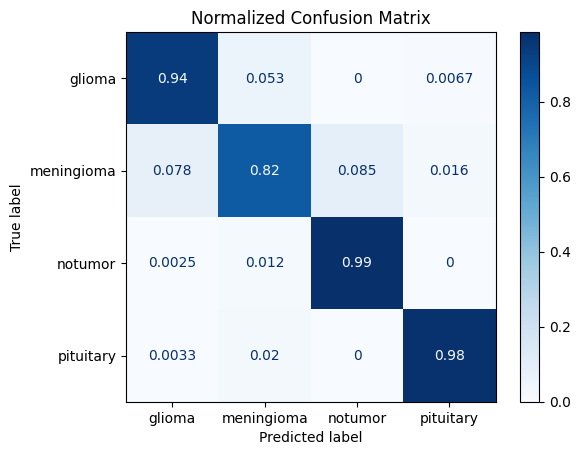

In [ ]:
cm = confusion_matrix(test_generator.classes, y_predicted, labels=list(dictionary.values()), normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

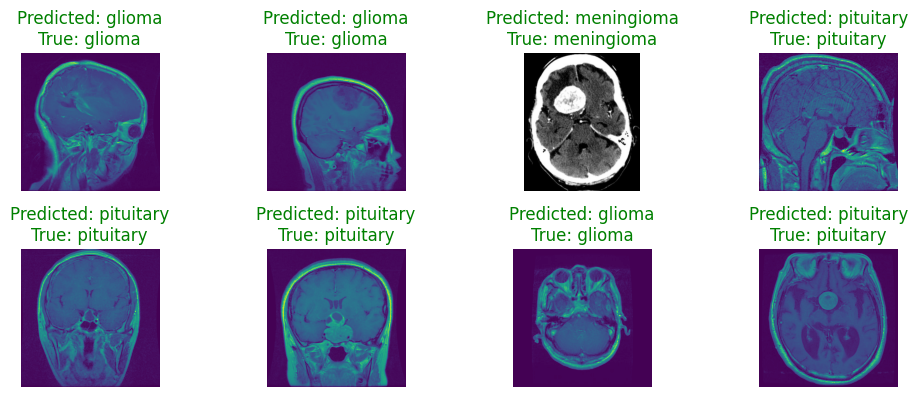

In [ ]:
def testingWithPlot(test_generator, y_predicted, categories):

    sample_indices = np.random.choice(len(test_generator.filepaths), size=8, replace=False)

    plt.figure(figsize=(10, 8))

    for i, index in enumerate(sample_indices):
        img = plt.imread(test_generator.filepaths[index])
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

        predicted_label = categories[y_predicted[index]]
        true_label = categories[test_generator.classes[index]]
        prediction_color = 'green' if predicted_label == true_label else 'red'
        plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}", color=prediction_color)

    plt.tight_layout()
    plt.show()

testingWithPlot(test_generator, y_predicted, classes)